In [1]:
# dependencies
import json as js
from collections import defaultdict
from pprint import pprint
from tqdm import tqdm
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

from sklearn.manifold import MDS

# set up a lemmatizer
lemmatizer = WordNetLemmatizer()

---

## Mapping Class IDs to Category Names

In [2]:
# obtain a mapping of IDs to low level categories (table, tv, book, etc.)
category, supercategory = dict(), dict()
with open('annotations/instances_val2017.json') as f:
    for cat in js.load(f)['categories']:
        category[cat['id']] = cat['name']
        supercategory[cat['name']] = cat['supercategory']
        
pprint({k:v for k,v in list(category.items())[:10]})
print('\n')
pprint({k:v for k,v in list(supercategory.items())[:10]})

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light'}


{'airplane': 'vehicle',
 'bicycle': 'vehicle',
 'boat': 'vehicle',
 'bus': 'vehicle',
 'car': 'vehicle',
 'motorcycle': 'vehicle',
 'person': 'person',
 'traffic light': 'outdoor',
 'train': 'vehicle',
 'truck': 'vehicle'}


---
## Mapping Classes to Images

In [3]:
# accumulate image IDs for each class
category_IDs = defaultdict(list)
with open('annotations/instances_train2017.json') as f:
    for im in tqdm(js.load(f)['annotations']):
        cat = category[im['category_id']]
        category_IDs[cat].append(im['image_id'])

100%|██████████| 860001/860001 [00:00<00:00, 1435192.11it/s]


In [4]:
print('ImageIDs of images containing an \'airplane\':\n')
print(category_IDs['airplane'][:10], '\tSize of class =', len(category_IDs['airplane']))

ImageIDs of images containing an 'airplane':

[253223, 504811, 81922, 153038, 497504, 341299, 78537, 412184, 145019, 451202] 	Size of class = 5135


---
## Mapping Images to Normalized Captions

In [5]:
def lemmatize(word, tag):
    if tag[0] == 'J':
        return lemmatizer.lemmatize(word, wn.ADJ)+'-adj'
    elif tag[0] == 'N':
        return lemmatizer.lemmatize(word, wn.NOUN)+'-noun'
    elif tag[0] == 'R':
        return lemmatizer.lemmatize(word, wn.ADV)+'-adv'
    elif tag[0] == 'V':
        return lemmatizer.lemmatize(word, wn.VERB)+'-verb'
    return None


# process captions and store by image_ID in dict
captions, vocab = defaultdict(list), defaultdict(int)
with open('annotations/captions_train2017.json') as f:
    for im in tqdm(js.load(f)['annotations']):
        caption = im['caption']
        
        # apply NLTK tokenizer
        tokens = word_tokenize(caption.lower())
        
        # normalize each token w.r.t their part-of-speech
        terms = [lemmatize(w, t) for w,t in pos_tag(tokens)]
        terms = [t for t in terms if t is not None]
        
        # update vocabulary
        for t in terms:
            vocab[t] += 1
        
        # update captions
        captions[im['image_id']] += terms
        
# transform vocab to index mapping
indices = {t:i for i,t in enumerate(vocab)}

100%|██████████| 591753/591753 [07:09<00:00, 1376.71it/s]


In [6]:
print('Image 452122', captions[359061])

Image 452122 ['be-verb', 'fighter-noun', 'plane-noun', 'row-noun', 'picture-noun', 'several-adj', 'old-adj', 'airplane-noun', 'stack-verb', 'top-noun', 'other-adj', 'line-noun', 'bomber-noun', 'airplane-noun', 'be-verb', 'fly-verb', 'air-noun', 'several-adj', 'american-adj', 'war-noun', 'plane-noun', 'fly-verb', 'special-adj', 'formation-noun', 'bunch-noun', 'army-noun', 'airplane-noun', 'line-verb', 'up-adv', 'beside-adv', 'other-adj', 'sky-noun']


--- 
## Merging Classes and Captions to obtain Word Vectors

In [7]:
N = sum([len(x) for x in captions.values()])
idf_vec = np.array([np.log(N/vocab[t]) for t in vocab])
print('idf vector', idf_vec[:6], '\n')

data = []
for cat, imIDs in tqdm(category_IDs.items()):
    vec = np.zeros(len(vocab), dtype=np.uint16)
    for imID in imIDs:
        for term in captions[imID]:
            vec[indices[term]] += 1
    data.append(vec*idf_vec)
data = np.array(data)

  0%|          | 0/80 [00:00<?, ?it/s]

idf vector [ 7.037878   11.38070892  5.74770663  5.21460853  8.50291595  5.25193108] 



100%|██████████| 80/80 [01:41<00:00,  1.80it/s]


In [8]:
print(np.round(data, 2))

[[  42.23   11.38    5.75 ...    0.      0.      0.  ]
 [1337.2    11.38  327.62 ...    0.      0.      0.  ]
 [2955.91   68.28 4569.43 ...    0.      0.      0.  ]
 ...
 [ 710.83   22.76  425.33 ...    0.      0.      0.  ]
 [   7.04    0.      0.   ...    0.      0.      0.  ]
 [  14.08    0.     68.97 ...    0.      0.      0.  ]]


---
## Reduce and Plot

/home/thomas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in arccos
  after removing the cwd from sys.path.


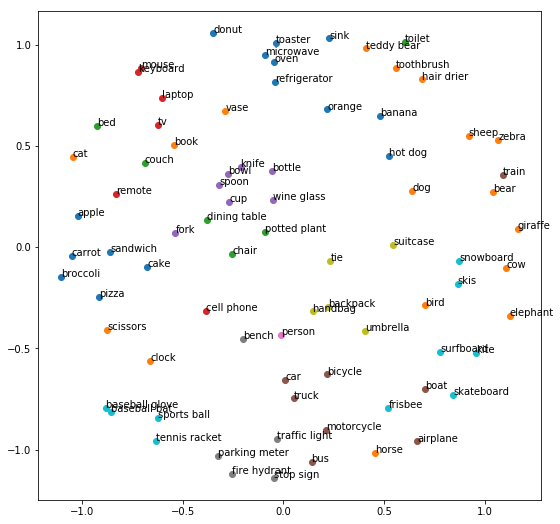

In [9]:
dist_mat = np.zeros((len(category_IDs), len(category_IDs)), dtype=np.float16)
for i, vec1 in enumerate(data):
    for j, vec2 in enumerate(data):
        dist_mat[i, j] = np.arccos(vec1.dot(vec2) / (norm(vec1)*norm(vec2)))
dist_mat = np.nan_to_num(dist_mat)


mds = MDS(n_components=2, dissimilarity='precomputed')
X = mds.fit_transform(dist_mat)


# sort results
groups = defaultdict(lambda: defaultdict(list))
for vec, c in zip(X, category_IDs.keys()):
    supercat = supercategory[c]
    groups[supercat]['vecs'].append(vec)
    groups[supercat]['cats'].append(c)
    
# plot each group
plt.figure(figsize=(9,9))
for group in groups.values():
    x = np.array(group['vecs'])
    plt.plot(x[:, 0], x[:, 1], 'o')
    for c, x in zip(group['cats'], group['vecs']):
        plt.annotate(c, x)
    
plt.show()
    